In [1]:
## @see https://www.kaggle.com/toorkp/churn-wsdm/data

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score, log_loss, confusion_matrix
from sklearn.neural_network import MLPClassifier

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *

In [4]:
base_dataset = pd.read_hdf('/home/dissertation/data/feat_eng_abt.h5', 'feat_eng_abt')
base_dataset.drop(['transaction_date_min', 'transaction_date_max'], axis = 1, inplace=True)
base_dataset.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,registration_init_time_dt,age_cat,total_order,...,payment_method_id_count,payment_plan_days_mode,payment_plan_days_mean,plan_list_price_mean,plan_lifetime_value,actual_amount_mean,total_actual_amount,is_auto_renew_mode,cancel_times,transaction_date_delta
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28,male,3,20131223,2013-12-23,28,6,...,2,0,10.00,49.67,298.00,149.00,894.00,True,1,700.00
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13,20,male,3,20131223,2013-12-23,20,5,...,3,30,25.40,125.40,627.00,125.40,627.00,False,0,344.00
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13,18,male,3,20131227,2013-12-27,18,18,...,1,30,30.00,149.00,2682.00,149.00,2682.00,False,0,530.00
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1,0,unknown,7,20140109,2014-01-09,0,19,...,2,30,25.63,125.47,2384.00,141.16,2682.00,True,3,413.00
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13,35,female,7,20140125,2014-01-25,35,24,...,1,30,26.25,105.38,2529.00,123.17,2956.00,True,2,586.00


In [3]:
cols_to_keep = ['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',\
                'registration_init_time', 'registration_init_time_dt',\
                'total_order', 'plan_list_price_mean', 'plan_lifetime_value',\
                'cancel_times']
base_dataset = base_dataset[cols_to_keep]

NameError: name 'base_dataset' is not defined

In [6]:
## Simple Data Prep 
base_dataset = base_dataset.drop(labels =['msno', 'bd', 'gender'], axis=1)

base_dataset = OHE(base_dataset, col = ['city', 'registered_via'])

## Simply drops records with NA ast this stage
base_dataset = clean_dataset(base_dataset)

print(base_dataset.shape)
base_dataset.head()

Categorical columns in dataset ['city', 'registered_via']
(858935, 44)
(858935, 44)


,is_churn,registration_init_time,registration_init_time_dt,total_order,plan_list_price_mean,plan_lifetime_value,cancel_times,ohe_city_10,ohe_city_11,ohe_city_12,...,ohe_registered_via_4,ohe_registered_via_5,ohe_registered_via_6,ohe_registered_via_7,ohe_registered_via_8,ohe_registered_via_9,ohe_registered_via_1,ohe_registered_via_18,ohe_registered_via_10,ohe_registered_via_-1
0,1,20131223,2013-12-23,6,49.67,298.00,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,20131223,2013-12-23,5,125.40,627.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,20131227,2013-12-27,18,149.00,2682.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,20140109,2014-01-09,19,125.47,2384.00,3,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,20140125,2014-01-25,24,105.38,2529.00,2,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [7]:
## Each entry in the list is a Tuple of
##   [ModelName, Model, HyperParams, ScoringMetric]
classifiers = [
    #('NB', GaussianNB(), {}, 'f1'),
    ('DT', DecisionTreeClassifier(), {"max_depth":[10,25,50], "min_samples_leaf":[5,10,15,30]}, 'recall'),
    #('DT', DecisionTreeClassifier(), {}, 'f1'),
    #('RF', RandomForestClassifier(), {}, 'f1'),
    #('LR', LogisticRegression(), {}, 'f1'),
    #('AB', AdaBoostClassifier(), {}, 'f1'),
    #('MLP', MLPClassifier(), {}, 'f1')
]

### Experiment 1.1 Baseline - Default Settings - No sampling

/home/anaconda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Applying normalisation to train and test sets


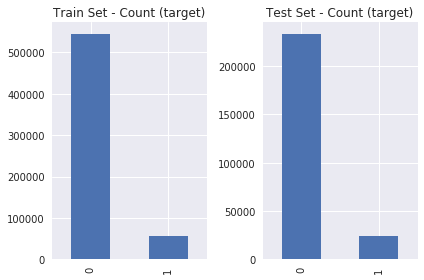

/home/anaconda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Applying normalisation to train and test sets
Building DT classifier
Optimising using GridSearchCV
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=10, min_samples_leaf=5 ................................
[CV] max_depth=10, min_samples_leaf=5 ................................
[CV] max_depth=10, min_samples_leaf=5 ................................
[CV] max_depth=10, min_samples_leaf=5 ................................
[CV] max_depth=10, min_samples_leaf=5 ................................
[CV] max_depth=10, min_samples_leaf=10 ...............................
[CV] max_depth=10, min_samples_leaf=10 ...............................
[CV] max_depth=10, min_samples_leaf=10 ...............................
[CV] ................. max_depth=10, min_samples_leaf=5, total=   5.0s
[CV] max_depth=10, min_samples_leaf=10 ...............................
[CV] ................. max_depth=10, min_samples_leaf=5, total=   5.0s
[CV] max_depth=10, min_samples_leaf=10 ....................

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.5s


[CV] max_depth=25, min_samples_leaf=15 ...............................
[CV] ................ max_depth=25, min_samples_leaf=10, total=  10.3s
[CV] max_depth=25, min_samples_leaf=15 ...............................
[CV] ................ max_depth=25, min_samples_leaf=10, total=  10.8s
[CV] max_depth=25, min_samples_leaf=30 ...............................
[CV] ................ max_depth=25, min_samples_leaf=10, total=  11.7s
[CV] max_depth=25, min_samples_leaf=30 ...............................
[CV] ................ max_depth=25, min_samples_leaf=10, total=  12.7s
[CV] max_depth=25, min_samples_leaf=30 ...............................
[CV] ................ max_depth=25, min_samples_leaf=15, total=  11.7s
[CV] max_depth=25, min_samples_leaf=30 ...............................
[CV] ................ max_depth=25, min_samples_leaf=15, total=  13.2s
[CV] max_depth=25, min_samples_leaf=30 ...............................
[CV] ................ max_depth=25, min_samples_leaf=15, total=  11.7s
[CV] m

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished


CLF: {'max_depth': 50, 'min_samples_leaf': 5}
Performing 10-fold CV on test set
P_Recall: 0.281; N_Recall: 0.985


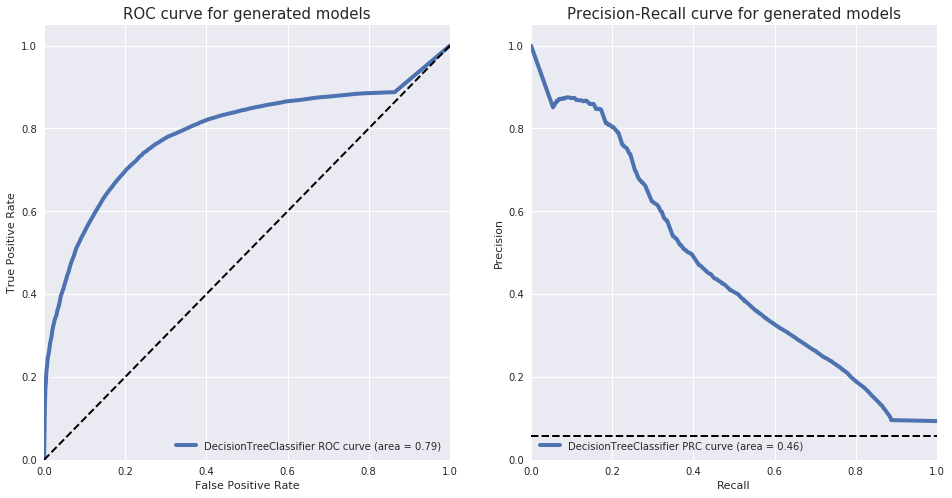

,classifier,sampling_method,sampling_ratio,tn,fn,tp,fp,accuracy,precision,recall,f1_score,log_loss,time_taken,aucroc,auprc,bal_acc,cv_score,model_churn_cost
0,DecisionTreeClassifier,None,None,230130,17314,6776,3461,0.92,0.66,0.28,0.39,2.78,75.21,0.79,0.46,0.63,"[0.3720653789004458, 0.37569060773480656, 0.39...",5009750.00


In [11]:
sampl_method = None
sampl_ratio = None

## sampling can be one of [None, 'under', 'over']
X_train, X_test, y_train, y_test = prepare_train_test_split(base_dataset, 0, sampl_method, sampl_ratio)

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Train Set - Count (target)')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar', title='Test Set - Count (target)')

plt.tight_layout()
plt.show()

model_build_results = train_model(base_dataset, 
                                  sampling_method = sampl_method, sample_ratio = sampl_ratio, 
                                  classifiers = classifiers)

metrics = model_build_results[0]

plot_data = []
for res in model_build_results[1]:
    model_name, model, (fpr, tpr, roc_auc), (precision, recall, prc_auc) = res
    plot_data.append((model_name, tpr, fpr, roc_auc, precision, recall, prc_auc))   
    
plot_roc_prc(plot_data)

metrics

### Experiment 1.2 Baseline - Default Settings - Oversampled training set 100%

In [ ]:
sampl_method = 'over'
sampl_ratio = 1.0

## sampling can be one of [None, 'under', 'over']
X_train, X_test, y_train, y_test = prepare_train_test_split(base_dataset, 0, sampl_method, sampl_ratio)

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Train Set - Count (target)')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar', title='Test Set - Count (target)')

plt.tight_layout()
plt.show()

model_build_results = train_model(base_dataset, 
                                  sampling_method = sampl_method, sample_ratio = sampl_ratio, 
                                  classifiers = classifiers)

metrics = pd.concat([metrics, model_build_results[0]])
metrics.sort_values(['auprc'], ascending=[False])

plot_data = []
for res in model_build_results[1]:
    model_name, model, (fpr, tpr, roc_auc), (precision, recall, prc_auc) = res
    plot_data.append((model_name, tpr, fpr, roc_auc, precision, recall, prc_auc))   
    
plot_roc_prc(plot_data)

metrics

### Experiment 1.3 Baseline - Default Settings - Undersampled training set

In [ ]:
sampl_method = 'under'
sampl_ratio = None

## sampling can be one of [None, 'under', 'over']
X_train, X_test, y_train, y_test = prepare_train_test_split(base_dataset, 0, sampl_method, sampl_ratio)

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Train Set - Count (target)')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar', title='Test Set - Count (target)')

plt.tight_layout()
plt.show()

model_build_results = train_model(base_dataset, 
                                  sampling_method = sampl_method, sample_ratio = sampl_ratio, 
                                  classifiers = classifiers)

metrics = pd.concat([metrics, model_build_results[0]])
metrics.sort_values(['auprc'], ascending=[False])

plot_data = []
for res in model_build_results[1]:
    model_name, model, (fpr, tpr, roc_auc), (precision, recall, prc_auc) = res
    plot_data.append((model_name, tpr, fpr, roc_auc, precision, recall, prc_auc))   
    
plot_roc_prc(plot_data)

metrics

### Experiment 1.4 Baseline - Default Settings - Over sampling - 33% of majority size

In [ ]:
sampl_method = 'over'
sampl_ratio = 0.33

## sampling can be one of [None, 'under', 'over']
X_train, X_test, y_train, y_test = prepare_train_test_split(base_dataset, 0, sampl_method, sampl_ratio)

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Train Set - Count (target)')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar', title='Test Set - Count (target)')

plt.tight_layout()
plt.show()

model_build_results = train_model(base_dataset, 
                                  sampling_method = sampl_method, sample_ratio = sampl_ratio, 
                                  classifiers = classifiers)

metrics = pd.concat([metrics, model_build_results[0]])
metrics.sort_values(['auprc'], ascending=[False])

plot_data = []
for res in model_build_results[1]:
    model_name, model, (fpr, tpr, roc_auc), (precision, recall, prc_auc) = res
    plot_data.append((model_name, tpr, fpr, roc_auc, precision, recall, prc_auc))   
    
plot_roc_prc(plot_data)

metrics

### Experiment 1.5 Baseline - Default Settings - Over sampling - 66% of majority size

In [ ]:
sampl_method = 'over'
sampl_ratio = 0.66

## sampling can be one of [None, 'under', 'over']
X_train, X_test, y_train, y_test = prepare_train_test_split(base_dataset, 0, sampl_method, sampl_ratio)

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Train Set - Count (target)')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar', title='Test Set - Count (target)')

plt.tight_layout()
plt.show()

model_build_results = train_model(base_dataset, 
                                  sampling_method = sampl_method, sample_ratio = sampl_ratio, 
                                  classifiers = classifiers)

metrics = pd.concat([metrics, model_build_results[0]])
metrics.sort_values(['auprc'], ascending=[False])

plot_data = []
for res in model_build_results[1]:
    model_name, model, (fpr, tpr, roc_auc), (precision, recall, prc_auc) = res
    plot_data.append((model_name, tpr, fpr, roc_auc, precision, recall, prc_auc))   
    
plot_roc_prc(plot_data)

metrics

### Experiment 1.6 Baseline - Default Settings - Over sampling - 50% of majority size

In [ ]:
sampl_method = 'over'
sampl_ratio = 0.5

## sampling can be one of [None, 'under', 'over']
X_train, X_test, y_train, y_test = prepare_train_test_split(base_dataset, 0, sampl_method, sampl_ratio)

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Train Set - Count (target)')

plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind='bar', title='Test Set - Count (target)')

plt.tight_layout()
plt.show()

model_build_results = train_model(base_dataset, 
                                  sampling_method = sampl_method, sample_ratio = sampl_ratio, 
                                  classifiers = classifiers)

metrics = pd.concat([metrics, model_build_results[0]])
metrics.sort_values(['auprc'], ascending=[False])

plot_data = []
for res in model_build_results[1]:
    model_name, model, (fpr, tpr, roc_auc), (precision, recall, prc_auc) = res
    plot_data.append((model_name, tpr, fpr, roc_auc, precision, recall, prc_auc))   
    
plot_roc_prc(plot_data)

metrics

In [ ]:
metrics.sort_values('model_churn_cost', ascending=True)

In [ ]:
## Just try an SVM 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time
model_train_results = train_model(base_dataset, sampling_method = 'under', classifiers = [('SGDClassifier', SGDClassifier(loss='log'))])

In [ ]:
## Print the feature importance 

feature_index = np.flip(np.argsort(model.feature_importances_), axis=0)
ordered_features = []
column_names = X_test.columns

for i in feature_index[0:10]:
    print(np.round(model.feature_importances_[i], 3), ' --> ', column_names[i])
    ordered_features.append(column_names[i])

In [ ]:
## Print the permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

_, X_test, _, y_test = prepare_train_test_split(model_dataset, 0)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
#model_name, model = model_train_results[1][2]

for model_name, model in model_train_results[1]:
    probs = model.predict_proba(X_test)[:, 1]
    pr_data = plot_precision_recall(
        y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
pr_data = plot_roc(
    y_test, probs, title='ROC Curve for {0}'.format(model_name))

In [ ]:
print(plt.style.available)

In [ ]:
model_dataset.head()

In [ ]:
print("Original Data distribution")
print(model_dataset['is_churn'].value_counts())

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Down Sampled data set')
train_downsample = undersampled_dataset(model_dataset, 'is_churn')

print(train_downsample['is_churn'].value_counts())
print("Num records = ", train_downsample.shape[0])
train_downsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Up Sampled data set')
train_upsample = oversampled_dataset(model_dataset, 'is_churn')

print(train_upsample['is_churn'].value_counts())
print("Num records = ", train_upsample.shape[0])
train_upsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for Random Forest')

In [ ]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

In [ ]:
threshold_required = 0.5
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [ ]:
model_dataset.head()

In [ ]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=model_dataset.iloc[:, 1:].columns).\
    sort_values('importance', ascending=False)
fi.head(10)